## What This Notebook Does

This notebook calculates how easy it is for people in each neighbourhood (LSOA) to access a MRI scanner, based on real travel times. We use a method called the Enhanced 3-Step Floating Catchment Area (E3SFCA), which goes beyond simple distance to include:

- Actual travel time by car and public transport
- Population demand per neighbourhood
- Number of MRI scanners available at each hospital or diagnostic centre
- A weighting system that gives more credit to closer facilities

### Step-by-Step Explanation

1. Identify the MRI Sites  
   We start by combining NHS Community Diagnostic Centres (CDCs) and Acute Hospitals, and we keep only those that actually have CT scanners.

2. Trim the Giant Travel Time Matrix  
   Instead of using all possible LSOA-to-LSOA travel times (millions of combinations), we filter the matrix to keep only the routes where the destination is a MRI scanner site, and only if the trip is reasonably short (e.g. under 60 minutes). This makes the data faster and easier to work with.

3. Apply a Travel Time Decay  
   We assume people are more likely to go to nearby scanners, so we apply a weighting system: short trips are weighted more heavily than long trips.

4. Calculate Supply-to-Demand Ratios  
   For each MRI scanner location, we calculate how many people (weighted by travel time) are trying to access it, and compare that to the number of scanners it has.

5. Score Each Neighbourhood  
   For every LSOA, we look at which MRI sites it can reach within the time limit. We sum the supply-to-demand ratios of those sites, adjusted for travel time, to get a final accessibility score.

6. Repeat for Each Travel Mode  
   We calculate separate scores for:
   - Car travel (e3sfca_score_car)
   - Public transport during peak hours (e3sfca_score_pt_peak)
   - Public transport during off-peak hours (e3sfca_score_pt_nonpeak)

7. Export and Visualise  
   These scores are added back to the LSOA GeoDataFrame so they can be visualised as maps or exported for further analysis.

### Why It Matters

This approach gives a realistic picture of NHS MRI scanner accessibility, accounting for both population demand and how hard it is to get to a scanner. It supports better planning, site placement, and equity assessments — especially across rural, deprived, or underserved areas.


In [34]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import warnings
import seaborn as sns
import mapclassify

warnings.filterwarnings("ignore")

# ----------------------------------------------------------
# Step 1 – Define File Paths and Load Processed Inputs (MRI)
# ----------------------------------------------------------

# Base directory structure
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# Input files (baseline access and facility logic)
lsoa_access_path = os.path.join(processed_dir, "gdf_lsoa_MRI_accessibility_2024.gpkg")
travel_matrix_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")
cdc_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Community_Diagnostic_Centres_Capability.csv")
acute_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Acute_Hospitals_Capability.csv")

# Ensure path to LSOA base demographic and demand file is defined (MRI)
lsoa_gpkg_path = os.path.join(
    processed_dir,
    "LSOA_MRI_Demand_with_Demographics_2024_v1.gpkg"
)

# Output folder
output_dir = os.path.join(base_dir, "outputs")
os.makedirs(output_dir, exist_ok=True)


In [35]:
# ----------------------------------------------------------
# Step 2 – Load Input Files (MRI)
# ----------------------------------------------------------

# Load baseline accessibility GeoDataFrame
gdf_lsoa = gpd.read_file(lsoa_access_path)
print(f"Baseline MRI LSOA access file loaded: {gdf_lsoa.shape}")

# Load site capability files
df_cdc = pd.read_csv(cdc_path)
df_acute = pd.read_csv(acute_path)
print(f"CDC sites: {df_cdc.shape[0]} rows | Acute sites: {df_acute.shape[0]} rows")

# Load travel matrix with car and PT times
df_travel = pd.read_csv(travel_matrix_path)
print(f"Travel matrix loaded: {df_travel.shape}")


Baseline MRI LSOA access file loaded: (3451, 7)
CDC sites: 24 rows | Acute sites: 18 rows
Travel matrix loaded: (11003925, 5)


In [36]:
# ----------------------------------------------------------
# Step 3 – Filter Travel Matrix to MRI-Capable Sites (Car Mode)
# ----------------------------------------------------------

# Combine CDC and Acute sites
df_sites = pd.concat([df_cdc, df_acute], ignore_index=True)

# Clean column names just in case
df_sites.columns = df_sites.columns.str.strip()

# Filter to MRI-capable sites only
df_sites_mri = df_sites[df_sites["MRI Scanners"] > 0].copy()
print(f"MRI-capable sites found: {df_sites_mri.shape[0]}")

# Extract valid LSOA codes where MRI scanners exist
mri_lsoa_codes = df_sites_mri["lsoa21cd"].dropna().unique()

# Filter travel matrix where destination is an MRI site (by LSOA code)
df_travel_car = df_travel[df_travel["destination_name"].isin(mri_lsoa_codes)].copy()
print(f"Filtered travel matrix for MRI destinations (car mode): {df_travel_car.shape}")

# Optional: Apply travel time threshold (e.g. ≤ 60 minutes)
df_travel_car = df_travel_car[df_travel_car["travel_time_car"] <= 60].copy()
print(f"Filtered travel matrix within 60 min (car): {df_travel_car.shape}")


MRI-capable sites found: 33
Filtered travel matrix for MRI destinations (car mode): (91151, 5)
Filtered travel matrix within 60 min (car): (17913, 5)


In [37]:
# ----------------------------------------------------------
# Step 4 – Column Header Checks (All Inputs) — MRI
# ----------------------------------------------------------

# Travel matrix columns
print("\nTravel Matrix Columns:")
print(df_travel.columns.to_list())

# MRI Sites table columns (after merge/filter)
print("\nMRI Site Capability Columns:")
print(df_sites_mri.columns.to_list())

# LSOA accessibility/demand GeoDataFrame columns
print("\nLSOA Accessibility/Demand Columns:")
print(gdf_lsoa.columns.to_list())

# Quick verification samples
print("\nSample travel matrix row:")
print(df_travel_car.head(1).T)

print("\nSample MRI site row:")
print(df_sites_mri[["Name", "MRI Scanners", "lsoa21cd", "latitude", "longitude"]].head(1).T)

print("\nSample LSOA access row:")
print(gdf_lsoa[["lsoa21cd", "mri_total_demand", "total_population"]].head(1).T)



Travel Matrix Columns:
['origin_name', 'destination_name', 'travel_time_car', 'travel_time_pt_peak', 'travel_time_pt_nonpeak']

MRI Site Capability Columns:
['Code', 'Name', 'CT Scanners', 'MRI Scanners', 'Endoscopy Rooms', 'Address 1', 'Address 2', 'Address 3', 'Address 4', 'Address 5', 'Postcode', 'Type', 'Parent Organisation Code', 'Parent Organisation Name', 'postcode', 'latitude', 'longitude', 'lsoa21cd', 'msoa21cd', 'oa21cd', 'icb_code', 'local_authority', 'Trust Name']

LSOA Accessibility/Demand Columns:
['lsoa21cd', 'mri_access_car_lt_20', 'mri_access_car_20_40', 'mri_access_car_gt_40', 'mri_total_demand', 'total_population', 'geometry']

Sample travel matrix row:
                              649
origin_name             E01014659
destination_name        E01015569
travel_time_car         46.115808
travel_time_pt_peak     80.075808
travel_time_pt_nonpeak  80.075808

Sample MRI site row:
                                   0
Name          Bsw Banes Locality CDC
MRI Scanners      

count    17913.000000
mean        39.774127
std         15.307046
min          0.000000
25%         28.447662
50%         43.964948
75%         52.592522
max         59.998693
Name: travel_time_car, dtype: float64


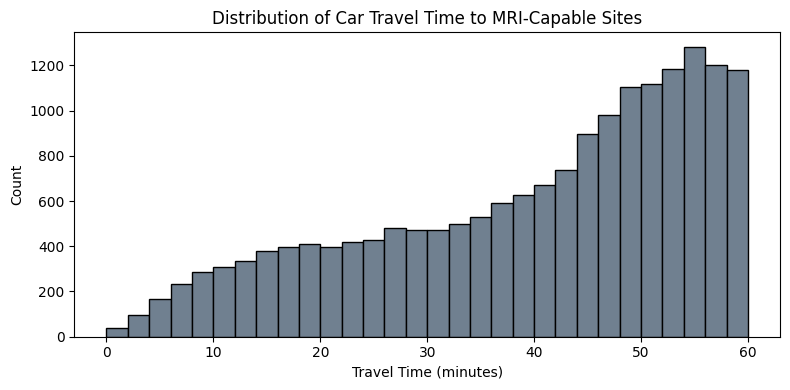

In [38]:
# Summary stats for car travel time to MRI-capable sites
print(df_travel_car["travel_time_car"].describe())

# Histogram to visualise travel time spread (MRI context)
plt.figure(figsize=(8, 4))
df_travel_car["travel_time_car"].hist(bins=30, color="slategray", edgecolor="black")
plt.title("Distribution of Car Travel Time to MRI-Capable Sites")
plt.xlabel("Travel Time (minutes)")
plt.ylabel("Count")
plt.grid(False)
plt.tight_layout()
plt.show()


In [39]:
# ----------------------------------------------------------
# Step 5 – Apply Travel Time Decay Function (MRI, Car Mode, 0–60 min)
# ----------------------------------------------------------

# Updated stepwise decay function (more granular across 0–60 min)
def apply_decay_car(travel_time):
    """
    Updated decay weights for car travel time (MRI context; df_travel_car is already
    filtered to MRI-capable destinations):
    - 0–10 min: 1.0
    - 10–20 min: 0.75
    - 20–30 min: 0.5
    - 30–40 min: 0.3
    - 40–50 min: 0.15
    - 50–60 min: 0.05
    - >60 min: 0.01 (shouldn’t occur but included for robustness)
    """
    if travel_time <= 10:
        return 1.0
    elif travel_time <= 20:
        return 0.75
    elif travel_time <= 30:
        return 0.5
    elif travel_time <= 40:
        return 0.3
    elif travel_time <= 50:
        return 0.15
    elif travel_time <= 60:
        return 0.05
    else:
        return 0.01

# Apply decay weights to the filtered travel matrix (car mode, MRI sites)
df_travel_car["decay_weight"] = df_travel_car["travel_time_car"].apply(apply_decay_car)

# Summary check: count of each decay weight
print("Decay weights applied (car mode, MRI destinations):")
print(df_travel_car["decay_weight"].value_counts().sort_index())


Decay weights applied (car mode, MRI destinations):
decay_weight
0.05    5961
0.15    4388
0.30    2715
0.50    2199
0.75    1830
1.00     820
Name: count, dtype: int64


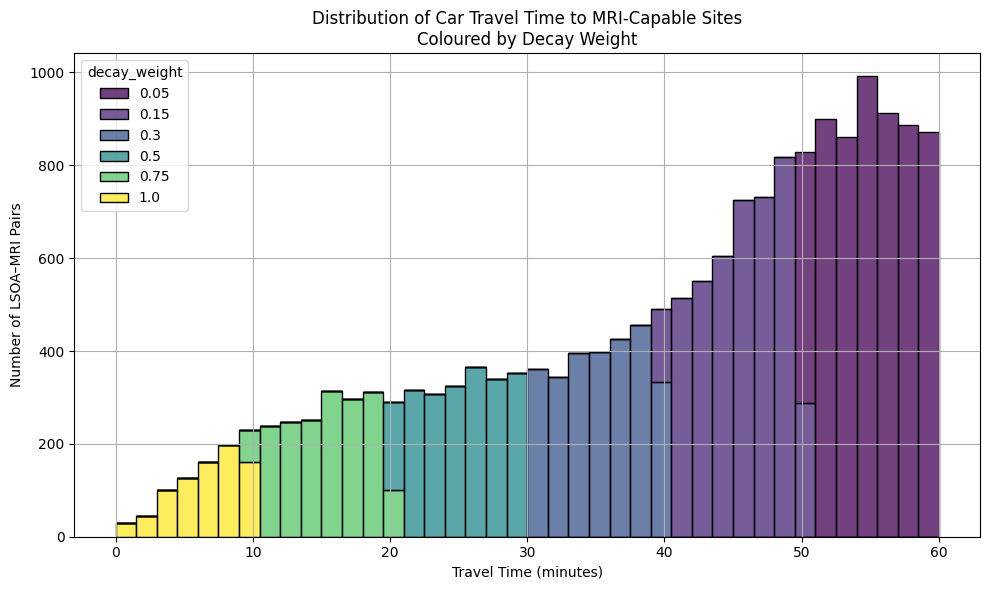

In [40]:
# ----------------------------------------------------------
# Step 5a – Visualise Decay Weights by Travel Time (Car Mode, MRI)
# ----------------------------------------------------------

# Set style
plt.style.use("default")

# Histogram of travel times with decay weights
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_travel_car,
    x="travel_time_car",
    bins=40,
    hue="decay_weight",
    palette="viridis",
    multiple="stack",
    edgecolor="black"
)
plt.title("Distribution of Car Travel Time to MRI-Capable Sites\nColoured by Decay Weight")
plt.xlabel("Travel Time (minutes)")
plt.ylabel("Number of LSOA–MRI Pairs")
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
# ----------------------------------------------------------
# Step 6 – Compute Supply-to-Demand Ratios at Each MRI Site (Rj)
# ----------------------------------------------------------

# 1. Clean merge keys just in case
df_travel_car["origin_name"] = df_travel_car["origin_name"].astype(str).str.strip()
gdf_lsoa["lsoa21cd"] = gdf_lsoa["lsoa21cd"].astype(str).str.strip()

# 2. Drop old demand columns from travel matrix if present
df_travel_car = df_travel_car.drop(columns=["mri_total_demand", "lsoa21cd"], errors="ignore")

# 3. Merge LSOA-level demand (mri_total_demand) into travel matrix
df_travel_car = df_travel_car.merge(
    gdf_lsoa[["lsoa21cd", "mri_total_demand"]],
    how="left",
    left_on="origin_name",
    right_on="lsoa21cd"
)

# 4. Drop merge helper column
df_travel_car.drop(columns=["lsoa21cd"], inplace=True, errors="ignore")

# 5. Drop rows with missing demand
df_travel_car = df_travel_car.dropna(subset=["mri_total_demand"])

# 6. Apply decay-weighted demand: Wᵢⱼ = Dᵢ × f(dᵢⱼ)
df_travel_car["weighted_demand"] = df_travel_car["mri_total_demand"] * df_travel_car["decay_weight"]

# 7. Group by site (destination_name) to get ∑ weighted demand
df_site_demand = df_travel_car.groupby("destination_name")["weighted_demand"].sum().reset_index()
df_site_demand.rename(columns={"weighted_demand": "total_weighted_demand"}, inplace=True)

# 8. Get scanner supply per site (MRI)
df_site_supply = df_sites_mri[["lsoa21cd", "MRI Scanners"]].copy()
df_site_supply.rename(columns={"lsoa21cd": "destination_name"}, inplace=True)

# 9. Merge demand + supply into one table
df_site_rj = df_site_demand.merge(df_site_supply, on="destination_name", how="left")

# 10. Assume 1 scanner if data is missing
df_site_rj["MRI Scanners"] = df_site_rj["MRI Scanners"].fillna(1)

# 11. Calculate supply-to-demand ratio Rj and scale: Rj_per_1000
df_site_rj["Rj"] = df_site_rj["MRI Scanners"] / df_site_rj["total_weighted_demand"]
df_site_rj["Rj_per_1000"] = df_site_rj["Rj"] * 1000

# 12. Output for next step
df_rj_car = df_site_rj[["destination_name", "Rj", "Rj_per_1000"]].copy()

# 13. Summary
print("Supply-to-demand ratios (Rj) calculated for MRI sites (car mode):")
print(df_rj_car.describe())


Supply-to-demand ratios (Rj) calculated for MRI sites (car mode):
              Rj  Rj_per_1000
count  27.000000    27.000000
mean    0.000135     0.135011
std     0.000080     0.080317
min     0.000026     0.026044
25%     0.000085     0.084999
50%     0.000125     0.124532
75%     0.000152     0.152130
max     0.000349     0.348945


In [42]:
# Step 7 – Compute Enhanced 3SFCA Scores (Ai) per LSOA — MRI
# -------------------------------------------------------

# 1. Merge Rj (supply-to-demand ratio per facility) into travel matrix
df_travel_car = df_travel_car.merge(
    df_rj_car[["destination_name", "Rj"]],
    on="destination_name",
    how="left"
)

# 2. Drop rows with missing Rj values
df_travel_car = df_travel_car.dropna(subset=["Rj"])

# 3. Compute accessibility contribution from each facility to each LSOA
# Ai = ∑ Rj × f(dij)
df_travel_car["access_contrib"] = df_travel_car["Rj"] * df_travel_car["decay_weight"]

# 4. Sum contributions by origin (LSOA) to get Ai
df_accessibility = df_travel_car.groupby("origin_name")["access_contrib"].sum().reset_index()
df_accessibility = df_accessibility.rename(
    columns={"origin_name": "lsoa21cd", "access_contrib": "enhanced_3sfca_score_mri"}
)

# 5. Merge back into gdf_lsoa
gdf_lsoa = gdf_lsoa.merge(df_accessibility, on="lsoa21cd", how="left")

# Optional: Fill NaNs with 0 if no accessibility
gdf_lsoa["enhanced_3sfca_score_mri"] = gdf_lsoa["enhanced_3sfca_score_mri"].fillna(0)


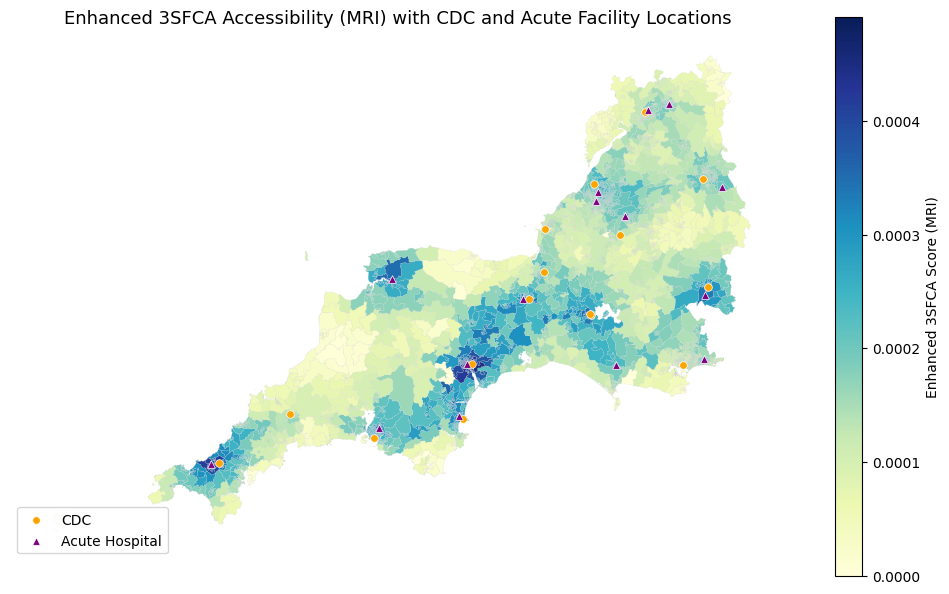

In [44]:
# ----------------------------------------------------------
# Step 8 – Visualise Enhanced 3SFCA Accessibility + Facility Locations (MRI)
# (robust to varying scanner column names)
# ----------------------------------------------------------

CMAP = "YlGnBu"

# 8.1 – Load
cdc_df   = pd.read_csv(cdc_path)
acute_df = pd.read_csv(acute_path)

# Helper: find/standardise MRI scanner count column -> 'scanner_count'
def standardise_scanner_count(df, site_label="site"):
    # 1) exact/common candidates
    candidates = [
        "scanner_count", "MRI Scanners", "MRI_Scanners", "MRI scanners",
        "mri_scanners", "mri scanner count", "mri_units", "mri_count",
        "mri_capacity", "Number of MRI Scanners", "No. of MRI Scanners",
        "Scanners_MRI"
    ]
    for c in candidates:
        if c in df.columns:
            df = df.rename(columns={c: "scanner_count"})
            return df, c

    # 2) fuzzy fallback: any column with 'mri' and one of these tokens
    tokens = ("scanner", "scanners", "unit", "units", "count", "capacity", "machine", "machines")
    fuzzy = [c for c in df.columns if ("mri" in c.lower() and any(t in c.lower() for t in tokens))]
    if fuzzy:
        df = df.rename(columns={fuzzy[0]: "scanner_count"})
        return df, fuzzy[0]

    # 3) last resort: create a default column of 1s
    df = df.copy()
    df["scanner_count"] = 1
    print(f"[WARN] No MRI scanner column found on {site_label}; defaulting scanner_count=1.")
    return df, None

cdc_df,   cdc_used   = standardise_scanner_count(cdc_df,   "CDC")
acute_df, acute_used = standardise_scanner_count(acute_df, "Acute")

# Filter for valid, active facilities
cdc_df_filtered = cdc_df[(cdc_df["scanner_count"] > 0) & (cdc_df["lsoa21cd"].notna())].copy()
acute_df_filtered = acute_df[(acute_df["scanner_count"] > 0) & (acute_df["lsoa21cd"].notna())].copy()

cdc_df_filtered["site_type"] = "CDC"
acute_df_filtered["site_type"] = "Acute"

# Combine into single facility dataframe (dedupe by LSOA to avoid overplot)
facilities_df = pd.concat([cdc_df_filtered, acute_df_filtered], ignore_index=True)\
                  .drop_duplicates(subset=["lsoa21cd"])

# Merge with LSOA geometry and convert to GeoDataFrame
facilities_gdf = facilities_df.merge(
    gdf_lsoa[["lsoa21cd", "geometry"]],
    on="lsoa21cd",
    how="left"
)
facilities_gdf = gpd.GeoDataFrame(facilities_gdf, geometry="geometry", crs=gdf_lsoa.crs)
facilities_gdf["geometry"] = facilities_gdf["geometry"].centroid  # use LSOA centroid for plotting

# Split by type
cdc_gdf   = facilities_gdf[facilities_gdf["site_type"] == "CDC"]
acute_gdf = facilities_gdf[facilities_gdf["site_type"] == "Acute"]

# 8.2 – Plot
fig, ax = plt.subplots(figsize=(10, 6))

# 3SFCA accessibility choropleth (MRI)
gdf_lsoa.plot(
    column="enhanced_3sfca_score_mri",
    cmap=CMAP,
    linewidth=0.1,
    edgecolor="lightgrey",
    legend=True,
    legend_kwds={"label": "Enhanced 3SFCA Score (MRI)"},
    ax=ax,
    missing_kwds={"color": "lightgrey"}
)

# Overlay CDCs (orange) and Acute (purple)
cdc_gdf.plot(
    ax=ax,
    color="orange",
    markersize=30,
    label="CDC",
    marker="o",
    edgecolor="white",
    linewidth=0.5
)
acute_gdf.plot(
    ax=ax,
    color="purple",
    markersize=30,
    label="Acute Hospital",
    marker="^",
    edgecolor="white",
    linewidth=0.5
)

# Final formatting
ax.set_title("Enhanced 3SFCA Accessibility (MRI) with CDC and Acute Facility Locations", fontsize=13)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)
plt.tight_layout()
plt.savefig("enhanced_3sfca_mri_with_facility_overlay.png", dpi=300, bbox_inches="tight")
plt.show()




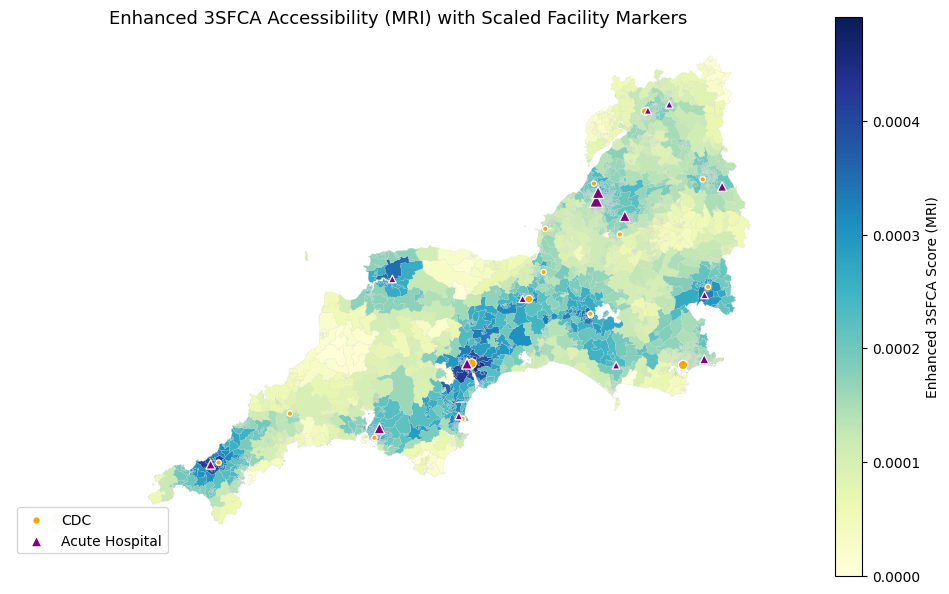

In [45]:
# ----------------------------------------------------------
# Step 8a – Facility Marker Size Scaled by Scanner Count (MRI)
# ----------------------------------------------------------

CMAP = "YlGnBu"  # optional: keep your colormap in one place

# Use already processed GeoDataFrames from Step 8:
# - gdf_lsoa (with enhanced_3sfca_score_mri)
# - cdc_gdf and acute_gdf (with scanner_count, site_type, geometry)

fig, ax = plt.subplots(figsize=(10, 6))

# Choropleth of 3SFCA accessibility (MRI)
gdf_lsoa.plot(
    column="enhanced_3sfca_score_mri",
    cmap=CMAP,
    linewidth=0.1,
    edgecolor="lightgrey",
    legend=True,
    legend_kwds={"label": "Enhanced 3SFCA Score (MRI)"},
    ax=ax,
    missing_kwds={"color": "lightgrey"}
)

# Scale: marker size = scanner_count × scale factor
size_scale = 15  # adjust for visibility

# CDC: orange circles sized by scanners
cdc_gdf.plot(
    ax=ax,
    color="orange",
    markersize=cdc_gdf["scanner_count"] * size_scale,
    label="CDC",
    marker="o",
    edgecolor="white",
    linewidth=0.9
)

# Acute: purple triangles sized by scanners
acute_gdf.plot(
    ax=ax,
    color="purple",
    markersize=acute_gdf["scanner_count"] * size_scale,
    label="Acute Hospital",
    marker="^",
    edgecolor="white",
    linewidth=0.9
)

# Final styling
ax.set_title("Enhanced 3SFCA Accessibility (MRI) with Scaled Facility Markers", fontsize=13)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)
plt.tight_layout()
plt.savefig("enhanced_3sfca_mri_scaled_markers.png", dpi=300, bbox_inches="tight")
plt.show()


In [47]:
# ----------------------------------------------------------
# Step 9 – Export E3SFCA Outputs to New Folder (MRI)
# ----------------------------------------------------------

# Define new export directory
e3sfca_dir = os.path.join(
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed",
    "E3SFCA"
)
os.makedirs(e3sfca_dir, exist_ok=True)

# 1. Export LSOA GeoDataFrame with E3SFCA (MRI) score
lsoa_gpkg_path = os.path.join(e3sfca_dir, "lsoa_e3sfca_mri_accessibility_2024.gpkg")
gdf_lsoa.to_file(lsoa_gpkg_path, layer="lsoa_mri", driver="GPKG")

# 2. Export CSV version (without geometry)
lsoa_csv_path = os.path.join(e3sfca_dir, "lsoa_e3sfca_mri_accessibility_2024.csv")
gdf_lsoa.drop(columns="geometry").to_csv(lsoa_csv_path, index=False)

# 3. Export filtered travel matrix (car mode only, ≤60 min, MRI destinations)
travel_car_path = os.path.join(e3sfca_dir, "lsoa_to_mri_travel_matrix_car.csv")
df_travel_car.to_csv(travel_car_path, index=False)

# 4. Export MRI site capability table (with scanner info and LSOA codes)
mri_sites_path = os.path.join(e3sfca_dir, "mri_sites_capability.csv")
df_sites_mri.to_csv(mri_sites_path, index=False)

# 5. Export Rj values (supply-to-weighted demand per MRI site)
rj_path = os.path.join(e3sfca_dir, "mri_site_rj_scores_car.csv")
df_rj_car.to_csv(rj_path, index=False)

print("All MRI E3SFCA files exported to:", e3sfca_dir)


All MRI E3SFCA files exported to: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/E3SFCA
